In [1]:
%load_ext ipydex.displaytools
import sympy as sp
from sympy import sin, cos
import numpy as np
import symbtools as st
import matplotlib.pyplot as plt
sp.init_printing()

In [2]:
theta1, theta2, theta3 = theta = st.symb_vector('theta1:4')

In [3]:
b1 = sp.Matrix([0, 0])
b2 = sp.Matrix([1, 0])
p1 = b1 + sp.Matrix([cos(theta1), sin(theta1)])
p2 = p1 + sp.Matrix([cos(theta1+theta2), sin(theta1+theta2)])
p3 = b2 + sp.Matrix([cos(theta3), sin(theta3)])

In [4]:
from ipywidgets import FloatSlider, interact

def merge_options(custom_options, **default_options):
    merged_options = default_options
    merged_options.update(custom_options)
    return merged_options

class VisualiserElement:
    def __init__(self, points_fun, init_fun, update_fun, kwargs):
        self.points_fun = points_fun
        self.init_fun = init_fun
        self.update_fun = update_fun
        self.kwargs = kwargs
        self.drawables = []
        
class Visualiser:
    def __init__(self, variables, **axes_options):
        self.variables = variables
        self.elements = []
        self.axes_options = axes_options
        
    def create_default_axes(self):
        fig = plt.figure()
        ax = plt.axes(**merge_options(self.axes_options, aspect='equal', xlim=(-2.0, 2.0), ylim=(-2.0, 2.0)))
        ax.grid()
        
        return fig, ax
    
    def plot(self, variables_values, axes=None):
        assert len(self.variables) == len(variables_values), f"You need to pass as many variable values as this visualiser has variables. Required: {len(self.variables)}, Given: {len(variables_values)}"
        
        fig = None
        if axes is None:
            fig, axes = self.create_default_axes()
            plt.close()
            
        self.plot_init(variables_values, axes)
        self.plot_update(variables_values, axes)
        if fig is not None:
            display(fig)
            
    def plot_init(self, variables_values, axes):
        drawables = []
        for element in self.elements:
            element.drawables = element.init_fun(axes, element.points_fun(*variables_values), element.kwargs)
            drawables += element.drawables
            
        return drawables
    
    def plot_update(self, variables_values, axes):
        drawables = []
        for element in self.elements:
            element.drawables = element.update_fun(axes, element.drawables, element.points_fun(*variables_values), element.kwargs)
            drawables += element.drawables
        
        return drawables
            
    def interact(self, fig=None, axes=None, **kwargs):
        widget_dict = dict()
        
        for var in self.variables:
            var_str = repr(var)
            if var_str in kwargs:
                widget_dict[var_str] = kwargs[var_str]
            else:
                widget_dict[var_str] = F(-5.0, 5.0, 0.1, 0.0)
                
        if fig is None or axes is None:
            fig, axes = self.create_default_axes()
        
        is_initialized = False
                
        def interact_fun(**kwargs):
            nonlocal is_initialized
            variables_values = [kwargs[repr(var_symbol)] for var_symbol in self.variables]
            
            if not is_initialized:
                self.plot_init(variables_values, axes)
                is_initialized = True
                
            self.plot_update(variables_values, axes)
            display(fig)
        
        interact(interact_fun, **widget_dict)
        
    def add_element(self, points, init_fun, update_fun, **kwargs):
        if not isinstance(points, sp.Matrix):
            if isinstance(points, list):
                points = st.col_stack(*points)
            else:
                raise Exception("'points' must be a SymPy matrix or a list of column vectors")
            
        points_fun = sp.lambdify(self.variables, points)
        self.elements.append(VisualiserElement(points_fun, init_fun, update_fun, kwargs))
        
    def add_linkage(self, points, **kwargs):
        self.add_element(points, init_linkage, update_linkage, **kwargs)
        
    def add_polygon(self, points, **kwargs):
        self.add_element(points, init_polygon, update_polygon, **kwargs)
        
def init_linkage(ax, points, kwargs):
    return ax.plot(points[0, :], points[1, :], **merge_options(kwargs, marker='o', ls='-', lw=3))

def update_linkage(ax, drawables, points, kwargs):
    drawables[0].set_data(points)
    return drawables

def init_polygon(ax, points, kwargs):
    poly = plt.Polygon(points.T, **kwargs)
    ax.add_patch(poly)
    
    return [poly]

def update_polygon(ax, drawables, points, kwargs):
    poly = drawables[0]
    poly.set_xy(points.T)
    
    return drawables
    
def F(min, max, step, value):
    return FloatSlider(min=min, max=max, step=step, value=value)

In [5]:
vis = Visualiser(theta, xlim=(-2.0, 2.5))
vis.add_linkage([b1, p1, p2], lw=4)
vis.add_linkage([b2, p3])
vis.add_polygon([b1, p2, p3], alpha=0.5)

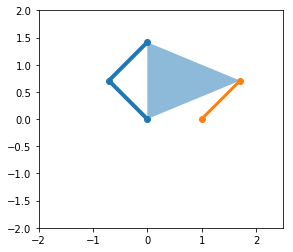

In [6]:
fig, ax = vis.create_default_axes()
ax.grid(False)
vis.plot([3*np.pi/4, -np.pi/2, np.pi/4], ax)

In [7]:
fig, ax = vis.create_default_axes()
ax.grid(False)
plt.close()
vis.interact(fig, ax, theta3=F(-0.5, 0.5, 0.05, 0.5))

interactive(children=(FloatSlider(value=0.0, description='theta1', max=5.0, min=-5.0), FloatSlider(value=0.0, …

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax.set_aspect('equal')
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])
ax.grid()

ax2 = plt.subplot(122)
ax2.grid()
ax2.set_xlim([0, 10])
ax2.set_ylim([-1.5, 1.5])
graph_drawables = ax2.plot([], [])

data = np.zeros((3, 300))
ts = np.linspace(0, 10, 300, endpoint=False)

def anim_init():
    vis_drawables = vis.plot_init([0.0, 0.0, 0.0], ax)
    
    return vis_drawables + graph_drawables

def anim_update(i):
    t = ts[i]
    t1 = 2*np.pi*0.25*t
    t2 = 2*np.pi*0.5*t
    t3 = 2*np.pi*0.3333*t
    
    data[0, i] = t1
    data[1, i] = t2
    data[2, i] = t3
    
    vis_drawables = vis.plot_update([t1, t2, t3], ax)
    
    graph_drawables[0].set_data(ts[:i+1], np.sin(data[0,:i+1]))
    
    return vis_drawables + graph_drawables

plt.close()

ani = animation.FuncAnimation(fig, anim_update, init_func=anim_init, frames=300, interval=1000/30)
HTML(ani.to_jshtml())